In [0]:
import os
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('/content/Mask_RCNN')
!pip3 install -r requirements.txt
!python3 setup.py install

# Get dataset from Drive

You need to have a Boracode/datasets/balloon folder in My Drive folder in you Google Drive structured as shown
***(may get it from [HERE](https://drive.google.com/drive/folders/17bXgnUeyujI90gB7I_bQY3kGcJZw5eng?usp=sharing))***

    Boracode
          datasets
                balloon
                      train
                            -images-
                            via-region-data.json
                       val
                            -images-
                            via-region-data.json


In [26]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
os.chdir('/content/Mask_RCNN')
!cp -r '/content/gdrive/My Drive/Boracode/datasets' .

# Prepare

In [0]:
#@title Setup {display-mode: "form"}
import os
os.chdir('/content/Mask_RCNN/samples/balloon')
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

############################################################
#  Configurations
############################################################


class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

Using TensorFlow backend.


**Dataset Definition**

In [0]:
class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("roof", 1, "roof")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "roof",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
            

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "roof":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "roof":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

**Load dataset**

In [0]:
dataset = BalloonDataset()
dataset.load_balloon('/content/Mask_RCNN/datasets/balloon', "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 10
Class Count: 2
  0. BG                                                
  1. roof                                              


#Train

In [0]:
#@title Set number of epochs
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = BalloonDataset()
    dataset_train.load_balloon('/content/Mask_RCNN/datasets/balloon', "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BalloonDataset()
    dataset_val.load_balloon('/content/Mask_RCNN/datasets/balloon', "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=3 #@param {type:"slider", min:1, max:30, step:1}
                ,layers='heads')
    
    
    
    
config = BalloonConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir='/content/Mask_RCNN/logs')
weights_path = COCO_WEIGHTS_PATH
# Download weights file
if not os.path.exists(weights_path):
       utils.download_trained_weights(weights_path)
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/balloon20190621T1302/mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeD

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/5
100/100 [==============================] - 362s 4s/step - loss: 1.2885 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 0.2410 - mrcnn_class_loss: 0.2721 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3637 - val_loss: 1.5802 - val_rpn_class_loss: 0.1409 - val_rpn_bbox_loss: 0.3287 - val_mrcnn_class_loss: 0.4867 - val_mrcnn_bbox_loss: 0.3245 - val_mrcnn_mask_loss: 0.2995
Epoch 2/5
100/100 [==============================] - 309s 3s/step - loss: 0.5323 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1876 - val_loss: 1.8077 - val_rpn_class_loss: 0.1758 - val_rpn_bbox_loss: 0.3635 - val_mrcnn_class_loss: 0.5829 - val_mrcnn_bbox_loss: 0.3427 - val_mrcnn_mask_loss: 0.3429
Epoch 3/5
100/100 [==============================] - 304s 3s/step - loss: 0.3499 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1408 - val_loss: 2.0184 - val_rpn_class_loss

# Run on image

In [0]:
#@title Setup {display-mode: "form"}
import sys
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




**Load model**

In [28]:
# Create model in inference mode
    model = modellib.MaskRCNN(mode="inference", model_dir='/content/Mask_RCNN/logs',
                              config=config)
  # Set path to balloon weights file
#load the last model you trained
weights_path = model.find_last()
#Get from google drive
#weights_path='content/gdrive/My Drive/model2.h5'
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/gdrive/My Drive/model.h5


**Select image**

--2019-06-21 13:40:56--  https://i.ibb.co/phP9W22/2.jpg
Resolving i.ibb.co (i.ibb.co)... 207.244.121.19
Connecting to i.ibb.co (i.ibb.co)|207.244.121.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267053 (261K) [image/jpeg]
Saving to: ‘/content/Mask_RCNN/samples/balloon/balloon.jpg’

/content/Mask_RCNN/ 100%[===================>] 260.79K  --.-KB/s    in 0.04s   

2019-06-21 13:40:56 (6.77 MB/s) - ‘/content/Mask_RCNN/samples/balloon/balloon.jpg’ saved [267053/267053]



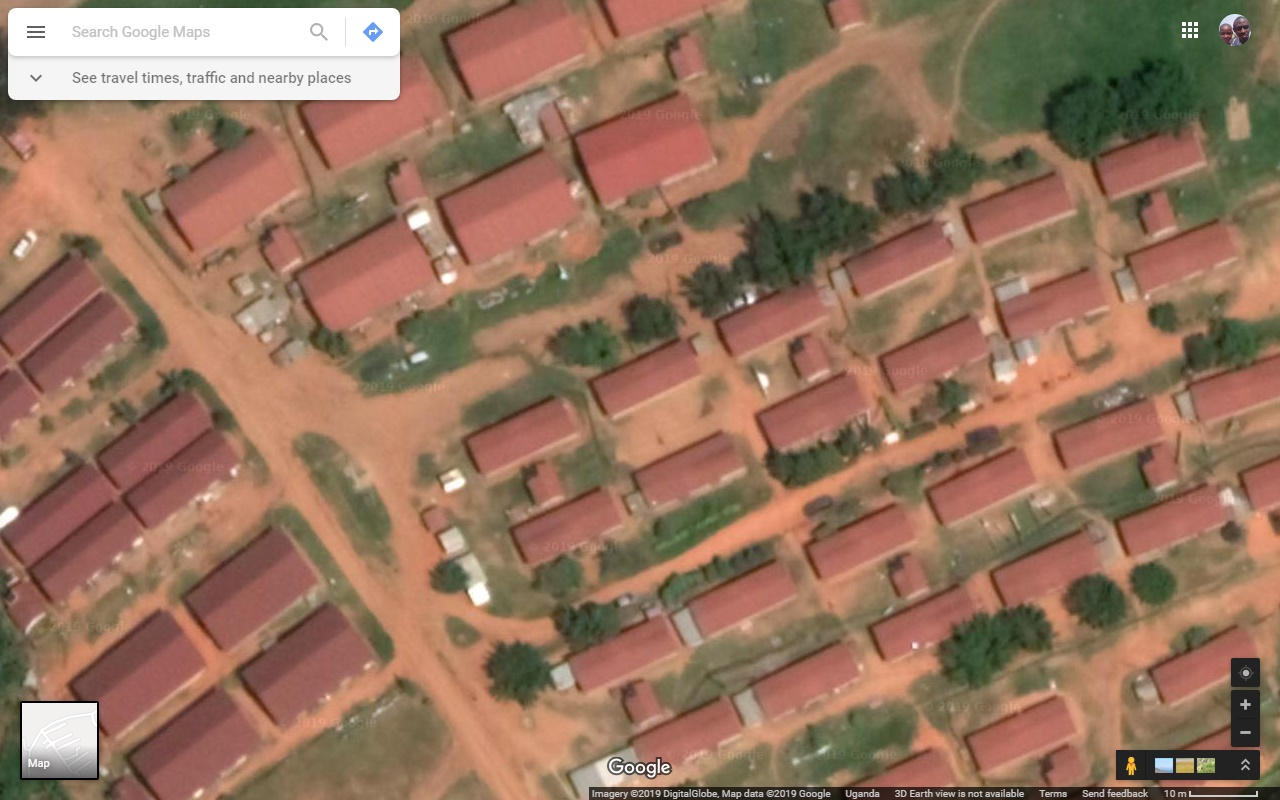

In [14]:
!wget -O '/content/Mask_RCNN/samples/balloon/balloon.jpg' 'https://i.ibb.co/phP9W22/2.jpg'
#https://i.ibb.co/2s0dfF4/balloon.jpg'#'https://www.scarymommy.com/wp-content/uploads/2014/10/little-girl-with-balloons.jpg?w=700'#'https://partycity6.scene7.com/is/image/PartyCity/_pdp_sq_?$_1000x1000_$&$product=PartyCity/237864'#'https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/InflatableBalloons.jpg/1024px-InflatableBalloons.jpg' #https://www.swiss-miss.com/wp-content/uploads/2009/05/balloon.jpg
filepath ='/content/Mask_RCNN/samples/balloon/balloon.jpg'
from IPython.display import Image
Image('/content/Mask_RCNN/samples/balloon/balloon.jpg')

#Detect

Processing 1 images
image                    shape: (800, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


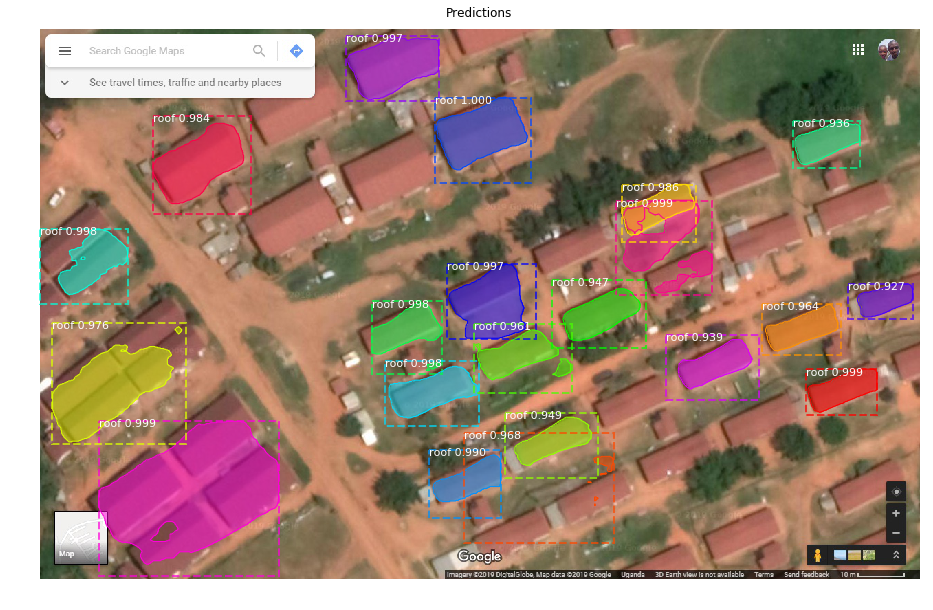

In [29]:
image = skimage.io.imread(filepath)
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

**Splash**

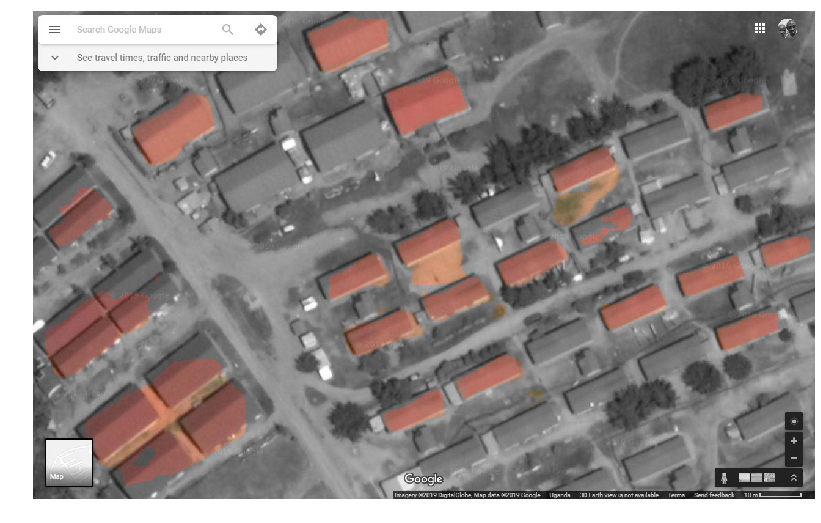

In [16]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)



---



# Miscellaneous

**Save model to Drive**

In [24]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title':'model.h5'})
uploaded.SetContentFile(weights_path)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

W0621 13:58:17.102739 140025494886272 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

Uploaded file with ID 1q2q6gRtsVK33mhe3lOTDGMrU9ydLcLH-


**Getting dataset for balloons**

In [0]:
#os.chdir('/content/Mask_RCNN')
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
#!unzip balloon_dataset.zip -d "datasets/"

**Generated Weights file**

In [0]:
#myCmd = os.popen('find /content/Mask_RCNN -name *.h5 -print0 | xargs -r -0 ls -1 -t | head -1')
#weights_path=myCmd.readline().rstrip('\n')
#print(weights_path)

**Get balloon weights**

In [0]:
#os.chdir('/content/Mask_RCNN')
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/mask_rcnn_balloon.h5

**Others**

In [0]:
#os.getcwd()

In [0]:
#!pip install 'keras==2.1.6' --force-reinstall